Set Up for the Agentic Rag

In [1]:
pip install -U --quiet langgraph "langchain[openai]" langchain-community langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importamos librerías necesarias
import os
from dotenv import load_dotenv

# Cargamos variables de entorno
dotenv_path = load_dotenv()

# Leemos las claves
token_openai = os.getenv("OPENAI_API_KEY")
token_tavily = os.getenv("TAVILY_API_KEY")

# Verificar que las claves existen
if not token_openai:
    raise ValueError("❌ Falta la clave OPENAI_API_KEY en el archivo .env")
if not token_tavily:
    raise ValueError("❌ Falta la clave TAVILY_API_KEY en el archivo .env")

print("✅ Claves cargadas correctamente")

✅ Claves cargadas correctamente


## 1 Preprocess the Documents

### 1. Scrap Xakata Web Site

In [3]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from langchain_core.documents import Document
from time import sleep

from typing import List, Set

import requests
from bs4 import BeautifulSoup

# --------------------------------------
# 1. Leer el sitemap_index.xml
# --------------------------------------

def get_category_sitemaps(index_url="https://www.xataka.com/sitemap_index.xml"):
    headers = {"User-Agent": "XaviBot/1.0"}
    response = requests.get(index_url, headers=headers)
    soup = BeautifulSoup(response.content, "xml")

    sitemaps = [loc.get_text() for loc in soup.find_all("loc")]
    return sitemaps

category_sitemaps = get_category_sitemaps()
print(f"Se han encontrado {len(category_sitemaps)} sitemaps.")
print("Ejemplo:", category_sitemaps[:3])

# --------------------------------------
# 2. Filtrar solo las categorías importantes
# --------------------------------------

important_categories = [
    "moviles", "portatiles", "ordenadores", "componentes",
    "perifericos", "televisores", "software", "internet",
    "inteligencia-artificial", "videojuegos", "gadgets"
]

filtered_sitemaps = [
    url for url in category_sitemaps
    if any(f"/{cat}/" in url for cat in important_categories)
]

print(f"\nSe han filtrado {len(filtered_sitemaps)} sitemaps relevantes.")
print("Ejemplo:", filtered_sitemaps[:3])

# --------------------------------------
# 3. Extraer URLs de artículos desde los sitemaps
# --------------------------------------

def get_articles_from_category_sitemap(sitemap_url, max_articles=10):
    headers = {"User-Agent": "XaviBot/1.0"}
    response = requests.get(sitemap_url, headers=headers)
    soup = BeautifulSoup(response.content, "xml")

    urls = [loc.get_text() for loc in soup.find_all("loc")]
    return urls[:max_articles]

all_articles = []
seen_urls = set()

for sitemap_url in filtered_sitemaps:
    print(f"Procesando {sitemap_url}")
    articles = get_articles_from_category_sitemap(sitemap_url, max_articles=10)

    for url in articles:
        if url not in seen_urls:
            category = url.split("/")[3] if len(url.split("/")) > 3 else "desconocida"
            all_articles.append({
                "url": url,
                "category": category
            })
            seen_urls.add(url)
    sleep(0.5)  # ser amable con el servidor

print(f"\nTotal artículos únicos extraídos: {len(all_articles)}")
for a in all_articles[:3]:
    print(a)

# --------------------------------------
# 4. Scraping del contenido: title + text
# --------------------------------------

def scrape_article(url, category):
    headers = {"User-Agent": "XaviBot/1.0"}
    try:
        
        response = requests.get(url, headers=headers, timeout=10)
        response.encoding = 'utf-8' # <-- aquí el fix

        if response.status_code != 200:
            return None

        soup = BeautifulSoup(response.text, "html.parser")

        title_tag = soup.find("h1")
        paragraphs = soup.find_all("p")

        if not title_tag or not paragraphs:
            return None

        title = title_tag.get_text(strip=True)
        content = "\n\n".join([p.get_text(strip=True) for p in paragraphs])

        return {
            "url": url,
            "title": title,
            "content": content,
            "category": category
        }
    except Exception as e:
        print(f"❌ Error en {url}: {e}")
        return None

# Ejecutar scraping de todos los artículos
scraped_articles = []

for article in all_articles:
    result = scrape_article(article["url"], article["category"])
    if result:
        scraped_articles.append(result)

print(f"\nTotal artículos correctamente scrapeados: {len(scraped_articles)}")
for a in scraped_articles[:10]:
    print(f"- {a['title']} ({a['category']})")




Se han encontrado 336 sitemaps.
Ejemplo: ['https://www.xataka.com/categoria/default/sitemap.xml', 'https://www.xataka.com/categoria/otros/sitemap.xml', 'https://www.xataka.com/categoria/moviles/sitemap.xml']

Se han filtrado 7 sitemaps relevantes.
Ejemplo: ['https://www.xataka.com/categoria/moviles/sitemap.xml', 'https://www.xataka.com/categoria/ordenadores/sitemap.xml', 'https://www.xataka.com/categoria/videojuegos/sitemap.xml']
Procesando https://www.xataka.com/categoria/moviles/sitemap.xml
Procesando https://www.xataka.com/categoria/ordenadores/sitemap.xml
Procesando https://www.xataka.com/categoria/videojuegos/sitemap.xml
Procesando https://www.xataka.com/categoria/perifericos/sitemap.xml
Procesando https://www.xataka.com/categoria/televisores/sitemap.xml
Procesando https://www.xataka.com/categoria/componentes/sitemap.xml
Procesando https://www.xataka.com/categoria/inteligencia-artificial/sitemap.xml

Total artículos únicos extraídos: 64
{'url': 'https://www.xataka.com/crossover/lg

### 2. Convertimos los documentos extraidos al formato Document que espera el Splitter

In [4]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content=article["content"],
        metadata={
            "title": article["title"],
            "url": article["url"],
            "category": article["category"]
        }
    )
    for article in scraped_articles
]

In [5]:
documents[0]

Document(metadata={'title': 'LG reinventó el móvil una y otra vez. Ese fue justo el error que la llevó al desastre: Crossover 1x29', 'url': 'https://www.xataka.com/crossover/lg-quiso-ser-distinta-a-todos-demas-sus-moviles-eso-fue-precisamente-que-condeno-crossover-1x29', 'category': 'crossover'}, page_content='Javier Pastor\n\nJavier Pastor\n\nHace más de cuatro años queLG cerró su división de móviles, una decisión que financieramente tenía sentido —no paraban de perder dinero—\xa0pero que a algunos usuarios —y me incluyo—\xa0nos dejó tocados.\n\nY es queLG tuvo su particular época doradaen este segmento. A principios de la década de 2010 la empresa era un referente absoluto: no en vano Google la eligió dos años seguidos para desarrollar y fabricar losNexus 4yNexus 5.\n\n\n\nPero es que además LG tuvo como decimosunos años fantásticostras lanzar elLG G2, un terminal que nos parecía casi gigantesco con sus 5,2 pulgadas y que planteaba una apuesta ambiciosa y destacable. Sobre todo porqu

#### 2.1 Chunking

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter 
from typing import List

def split_documents(
    docs: List[Document],
    chunk_size: int = 500,
    chunk_overlap: int = 100
) -> List[Document]:
    """
    Divide documentos largos en fragmentos más pequeños usando RecursiveCharacterTextSplitter.

    Args:
        docs: Lista de Documentos de LangChain.
        chunk_size: Tamaño máximo de cada fragmento.
        chunk_overlap: Número de caracteres que se solapan entre fragmentos.

    Returns:
        Lista de documentos divididos.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunked = text_splitter.split_documents(docs)
    print(f"📄 Documentos originales: {len(docs)} → 🧩 Chunks generados: {len(chunked)}")
    return chunked


In [7]:
doc_splits = split_documents(documents, chunk_size=500, chunk_overlap=200)

print(f"Se han generado {len(doc_splits)} fragmentos.")

📄 Documentos originales: 32 → 🧩 Chunks generados: 294
Se han generado 294 fragmentos.


In [8]:
doc_splits[0].page_content.strip()

'Javier Pastor\n\nJavier Pastor\n\nHace más de cuatro años queLG cerró su división de móviles, una decisión que financieramente tenía sentido —no paraban de perder dinero—\xa0pero que a algunos usuarios —y me incluyo—\xa0nos dejó tocados.\n\nY es queLG tuvo su particular época doradaen este segmento. A principios de la década de 2010 la empresa era un referente absoluto: no en vano Google la eligió dos años seguidos para desarrollar y fabricar losNexus 4yNexus 5.\n\n\n\nPero es que además LG tuvo como decimosunos años fantásticostras lanzar elLG G2, un terminal que nos parecía casi gigantesco con sus 5,2 pulgadas y que planteaba una apuesta ambiciosa y destacable. Sobre todo porque entre otras cosas "escondía" los botones físicos y los colocaba detrás de la pantalla.\n\nElLG G3también iba en buena dirección, pero a partir de ahí comenzaron los tropiezos y esa línea errática deunos terminales que eran impredecibles: la firma nos sorprendía cada año con decisiones distintas que parecían 

In [9]:
doc_splits[1].page_content.strip()

'ElLG G3también iba en buena dirección, pero a partir de ahí comenzaron los tropiezos y esa línea errática deunos terminales que eran impredecibles: la firma nos sorprendía cada año con decisiones distintas que parecían más destinadas a llamar la atención y provocar un efecto "wow" que a resolver verdaderos problemas.\n\nEs lo que vimos en aquella carcasa trasera de cuero sintético de losLG G4y sobre todo en ese diseño modular de losLG G5que no terminó de cuajar. Por el camino fueron quedando otras gamas como la V y por supuesto sus intentos para vender sus gamas media, que lo tuvieron muy difícil ante el empuje de Samsung y de los fabricantes chinos.\n\nDesde entonces, las cosas siguieron sin ir bien con sus terminales.LG seguía siendo valiente y original, pero una y otra vez el mercado respondía con la indiferencia: el mundo parecía querer móviles más "aburridos".\n\nModelos locos como elLG Wingacabaron por condenar a una empresa que acabó rindiéndose a la evidencia para centrarse en

In [10]:
doc_splits[2].page_content.strip()

'Modelos locos como elLG Wingacabaron por condenar a una empresa que acabó rindiéndose a la evidencia para centrarse en otras divisiones que son un éxito absoluto, como la que se encarga dedesarrollar paneles OLEDpara sus TVs pero también para diversos fabricantes como Apple.\n\nEn YouTube |Crossover\n\nEn Xataka |15 móviles valientes de LG que intentaron cambiar el mundo (y no lo lograron)\n\nLos mejores comentarios:\n\nVer6 comentarios\n\nEn Xataka hablamos de...\n\nVer más temas\n\nWebedia\n\nTecnología\n\nVideojuegos\n\nEntretenimiento\n\nGastronomía\n\nMotor\n\nEstilo de vida\n\nEconomía\n\nEdiciones Internacionales\n\nPartners\n\nDestacamos\n\nVer más temas\n\nSuscribir\n\nMás sitios que te gustarán\n\nReciente\n\nVer más artículos\n\nXatakaTV\n\nVer más vídeos'

## 2. Creamos el retriever tool en memoria.

### 1. Use an in-memory vector store and OpenAI embeddings

In [11]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
#Lo dejo para demostrar que los embeddings tienen una cierta cantidad de tokens con lo cual es mejor partir
# vectorstore = InMemoryVectorStore.from_documents(
#     documents=doc_splits, embedding=OpenAIEmbeddings()
# )
# retriever = vectorstore.as_retriever()
vectorstore = InMemoryVectorStore(embedding=OpenAIEmbeddings())

In [12]:
# 2. Procesa por batches (lotes). Tenemos que procesar por lotes por que no admite mas de 300000  tokens
batch_size = 500

for i in range(0, len(doc_splits), batch_size):
    batch = doc_splits[i:i + batch_size]
    # Procesa cada batch aquí. Ejemplo: añade al VectorStore
    vectorstore.add_documents(batch)
    print(f"Procesando batch {i//batch_size + 1} con {len(batch)} chunks...")

    # Aquí va tu código de procesamiento, por ejemplo:
    # vectorstore.add_documents(batch)

Procesando batch 1 con 294 chunks...


In [13]:
retriever = vectorstore.as_retriever()

### 2. Creamos una retriever **tool** usando LangChain's prebuilt create_retriever_tool:

In [14]:

from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",#nombre
    "Busca y devuelve info acerca de articulos de Xakata.",#Descripcion
)

In [15]:
# retriever_tool.invoke({"query": "¿Como se actualiza un Google Pixel?"})

# retriever_tool.invoke({"query": "Galaxy Z Flip7 "})
# 
retriever_tool.invoke({"query": "¿Como Samsung a adelanto Google?"})

'Como en las gafas de Apple, Android XR y las cámaras de seguimiento ocular en el interior de las Galaxy XR permiten que nuestros ojos nos permitan movernos por la interfaz y seleccionar objetos y opciones para luego hacer gestos con los dedos que permiten "hacer clics", hacer scroll en sitios web, bajar y subir el volumen o redimensionar ventanas, por ejemplo.\n\nEl aspecto de esa interfaz es el de Android XR, pero con un diseño e interacción que una vez másson básicamente los mismos que Apple planteó con visionOS. Samsung promete entornos inmersivos, fotos espaciales —hay además opción para convertir fotos 2D en fotos espaciales—\xa0y la capacidad de conectarnos a un PC o portátil para usar las gafas como monitor externo en el que abrir varias ventanas.\n\nSin embargo, una ventaja potencial de estas gafas que en Android XRcontamos con la potencia de Gemini. Los directivos de Samsung y Google incidieron en una conversación con medios en que este dispositivo tenía "IA en su núcleo" en 

### 3. Test the tool

## 3. Generamos la Query.
Ahora comenzaremos a construir los componentes (nodos y aristas) para nuestro grafo agentic RAG. Ten en cuenta que los componentes operarán sobre el MessagesState — el estado del grafo que contiene una clave messages con una lista de mensajes de chat.

### 1.Construir un **nodo genera_query_o_responde**. Este llamará a un LLM para generar una respuesta basada en el estado actual del grafo (lista de mensajes). Dado el conjunto de mensajes de entrada, decidirá si recuperar información usando la herramienta de recuperación (retriever tool), o responder directamente al usuario. Ten en cuenta que le estamos dando acceso al modelo conversacional a la herramienta de recuperación que creamos antes, a través de .bind_tools:

In [36]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI

response_model=  ChatOpenAI(model="gpt-4o", temperature=0)

def genera_query_o_responde(state: MessagesState):
    """Llama al modelo para generar una respuesta basada en el estado actual.
      Dada la pregunta, decidirá si recupera información usando la herramienta de recuperación o simplemente responde al usuario."""
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

### 2. Lo probamos con una pregunta aleatoria que no tenga que ver con la info obtenida

In [37]:
input = {"messages": [{"role": "user", "content": "¿Cuanto vale una cortina?"}]}
respuesta= genera_query_o_responde(input)
print (respuesta)

{'messages': [AIMessage(content='El precio de una cortina puede variar ampliamente dependiendo de varios factores, como el material, el tamaño, el diseño, la marca y el lugar donde se compre. Aquí hay algunos rangos generales de precios:\n\n1. **Cortinas de tela básica**: Pueden costar desde $10 hasta $50 por panel, dependiendo del tamaño y la calidad de la tela.\n\n2. **Cortinas de lujo o de diseñador**: Estas pueden costar desde $100 hasta varios cientos de dólares por panel.\n\n3. **Cortinas opacas o blackout**: Generalmente cuestan más que las cortinas estándar debido a su capacidad para bloquear la luz. Los precios pueden variar desde $20 hasta $100 por panel.\n\n4. **Cortinas personalizadas**: Si decides hacer cortinas a medida, el costo puede ser significativamente más alto, dependiendo de las especificaciones.\n\n5. **Cortinas de bambú o madera**: Estas pueden costar entre $30 y $200, dependiendo del tamaño y la calidad.\n\n6. **Cortinas de baño**: Generalmente son más económic

In [38]:
#cogemos el ultimo mensaje
respuesta["messages"][-1]

AIMessage(content='El precio de una cortina puede variar ampliamente dependiendo de varios factores, como el material, el tamaño, el diseño, la marca y el lugar donde se compre. Aquí hay algunos rangos generales de precios:\n\n1. **Cortinas de tela básica**: Pueden costar desde $10 hasta $50 por panel, dependiendo del tamaño y la calidad de la tela.\n\n2. **Cortinas de lujo o de diseñador**: Estas pueden costar desde $100 hasta varios cientos de dólares por panel.\n\n3. **Cortinas opacas o blackout**: Generalmente cuestan más que las cortinas estándar debido a su capacidad para bloquear la luz. Los precios pueden variar desde $20 hasta $100 por panel.\n\n4. **Cortinas personalizadas**: Si decides hacer cortinas a medida, el costo puede ser significativamente más alto, dependiendo de las especificaciones.\n\n5. **Cortinas de bambú o madera**: Estas pueden costar entre $30 y $200, dependiendo del tamaño y la calidad.\n\n6. **Cortinas de baño**: Generalmente son más económicas, con precio

In [39]:
#Formateamos el mensaje
respuesta["messages"][-1].pretty_print()

================================== Ai Message ==================================

El precio de una cortina puede variar ampliamente dependiendo de varios factores, como el material, el tamaño, el diseño, la marca y el lugar donde se compre. Aquí hay algunos rangos generales de precios:

1. **Cortinas de tela básica**: Pueden costar desde $10 hasta $50 por panel, dependiendo del tamaño y la calidad de la tela.

2. **Cortinas de lujo o de diseñador**: Estas pueden costar desde $100 hasta varios cientos de dólares por panel.

3. **Cortinas opacas o blackout**: Generalmente cuestan más que las cortinas estándar debido a su capacidad para bloquear la luz. Los precios pueden variar desde $20 hasta $100 por panel.

4. **Cortinas personalizadas**: Si decides hacer cortinas a medida, el costo puede ser significativamente más alto, dependiendo de las especificaciones.

5. **Cortinas de bambú o madera**: Estas pueden costar entre $30 y $200, dependiendo del tamaño y la calidad.

6. **Cortinas de 

### 3. Hacer una pregunta que requiera búsqueda semántica

In [40]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "¿Cómo adelantó Samsumng a Google",
        }
    ]
}
genera_query_o_responde(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_vvGdMnyAmiD7jvegHSuiHIgY)
 Call ID: call_vvGdMnyAmiD7jvegHSuiHIgY
  Args:
    query: Samsung adelanta a Google


## 4. Vemos la relevanciade los documentos

###  1.  Añade una arista condicional —grade_documents— para determinar si los documentos recuperados son relevantes para la pregunta. <span style="color:red">Utilizaremos un modelo con un esquema de salida estructurado llamado GradeDocuments</span> para la calificación de documentos. La función grade_documents devolverá el nombre del nodo al que se debe ir según la decisión de calificación (genera respuesta o reescribe_pregunta):

Conceptos a recordar: 
* <span style="color:red">arista condicional</span>

In [42]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "Eres un evaluador que determina la relevancia de un documento recuperado respecto a una pregunta del usuario. \n "
    "Aquí tienes el documento recuperado: \n\n {context} \n\n"
    "Aquí tienes la pregunta del usuario: {question} \n"
    "Si el documento contiene palabra(s) clave o significado semántico relacionado con la pregunta del usuario, califícalo como relevante. \n"
    "Da una puntuación binaria 'si' o 'no' para indicar si el documento es relevante para la pregunta."

)


class GradeDocuments(BaseModel):
    """Califica los documentos utilizando una puntuación binaria para comprobar su relevancia"""

    binary_score: str = Field(
        description="Puntuación : 'si' si es relevante, o 'no' si no lo es"
    )


grader_model = init_chat_model("openai:gpt-4.1", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["genera_respuesta", "rescribir_question"]:
    """Determina si los documentos recuperados son relevantes para la pregunta."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    print ("question:",question)
    print("context: ", context)
    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    print ("score :", score)
    if score == "si":
        return "genera_respuesta"
    else:
        return "rescribir_question"

### 2. Ejecutar con una respuesta irrelevante en la respuesta de la tool :

In [43]:
#simulamos la respuesta de la tool mediante mensajes
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Que tiempo hace en Alcante?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "Tiempo en Alicante"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},
        ]
    )
}

print ("input:" , input)
grade_documents(input)

input: {'messages': [HumanMessage(content='¿Que tiempo hace en Alcante?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Tiempo en Alicante'}, 'id': '1', 'type': 'tool_call'}]), ToolMessage(content='Son las 10 de la mañana', tool_call_id='1')]}
question: ¿Que tiempo hace en Alcante?
context:  Son las 10 de la mañana
score : no


'rescribir_question'

### 3. Confirmar que el documento/respuesta relavante se  clasifica como tal:

In [44]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Cómo Samsung a adelanto Google?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Cómo Samsung a adelanto Google?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Samsung fue la primera en lograr algo insólito: adelantar a Google en política de actualizaciones. El fabricante ofrecesiete años de actualizaciones de sistemay otros siete años de parches de seguridad.",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

question: ¿Cómo Samsung a adelanto Google?
context:  Samsung fue la primera en lograr algo insólito: adelantar a Google en política de actualizaciones. El fabricante ofrecesiete años de actualizaciones de sistemay otros siete años de parches de seguridad.
score : si


'genera_respuesta'

## 5 Rescribir la pregunta.

### 1. Construye el nodo de reescritura de pregunta (rescribir_question).
La herramienta de recuperación puede devolver documentos potencialmente irrelevantes, lo que indica la necesidad de mejorar la pregunta original del usuario. Para ello, llamaremos al nodo rewrite_question.

In [47]:
REWRITE_PROMPT = (
    "Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.\n"
    "Pregunta original:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:"
)


def rescribir_question(state: MessagesState):
    """Rescribe/Mejora la pregunta original del usuario."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    print ("xavi Prompt",prompt)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

#### 2. Try it out:

In [48]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Cómo Samsung a adelanto Google?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Cómo Samsung a adelanto Google?"},
                    }
                ],
            },
            {"role": "tool", "content": "Son las 10 de la mañana", "tool_call_id": "1"},
        ]
    )
}

response = rescribir_question(input)
print(response["messages"][-1]["content"])

xavi Prompt Analiza detenidamente la siguiente pregunta e intenta comprender la intención o el significado profundo que transmite.
Pregunta original:
 ------- 
¿Cómo Samsung a adelanto Google?
 ------- 
Ahora, reescribe la pregunta para que sea más clara, precisa y fácil de entender:
¿Cómo ha logrado Samsung superar a Google?


## 6. Generamos la Respuesta.

### 1. Construimos el nodo generate_answer.
Si superamos las comprobaciones del evaluador (grader), podemos generar la respuesta final basándonos en la pregunta original y el contexto recuperado

In [49]:
GENERATE_PROMPT = (
    "Eres un asistente para tareas de preguntas y respuestas. "
    "Utiliza los siguientes fragmentos de contexto recuperado para responder a la pregunta. "
    "Si no sabes la respuesta, simplemente indica que no la sabes. "
    "Utiliza un máximo de tres frases y mantén la respuesta concisa.\n"
    "Pregunta: {question} \n"
    "Contexto: {context}"
)



def genera_respuesta(state: MessagesState):
    """Genera la respuesta."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

### 2. Try it out.

In [50]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "¿Cómo ha logrado Samsung superar a Google?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "¿Cómo ha logrado Samsung superar a Google?"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Samsung fue la primera en lograr algo insólito: adelantar a Google en política de actualizaciones. El fabricante ofrecesiete años de actualizaciones de sistemay otros siete años de parches de seguridad.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = genera_respuesta(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Samsung ha logrado superar a Google en política de actualizaciones al ofrecer siete años de actualizaciones de sistema y otros siete años de parches de seguridad, lo cual es más extenso que lo que ofrece Google.


## 7. Configurar el grafo

### 7.1 Importamos los elementos necesarios para construir el grafo

In [51]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### 7.2 Ensamblamos el workflow

#### 7.2.1 Añadimos los nodos

In [52]:
workflow = StateGraph(MessagesState)
workflow.add_node(genera_query_o_responde)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rescribir_question)
workflow.add_node(genera_respuesta)

#### 7.2.2 Añadimos las aristas

In [53]:
workflow.add_edge(START, "genera_query_o_responde")
workflow.add_conditional_edges(
    "genera_query_o_responde",
    # Evalúa la decisión del LLM (llama a la herramienta retriever_tool o responde al usuario)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

#
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)

workflow.add_edge("genera_respuesta", END)

workflow.add_edge("rescribir_question", "genera_query_o_responde")

#### 7.2.3 Compilamos el grafo

In [54]:
graph = workflow.compile()

#### 7.2.4 Pintamos el Grafo

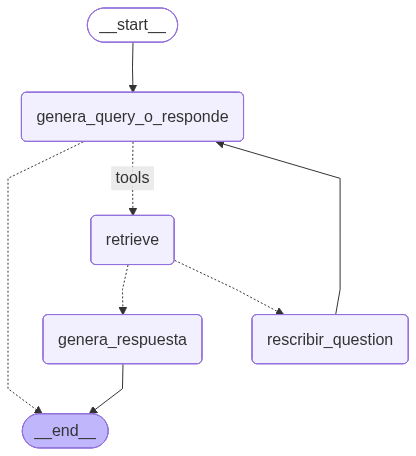

In [55]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


### NOtas

In [56]:
from pprint import pprint  # para imprimir bonito

# for chunk in graph.stream(
#     {
#         "messages": [
#             {
#                 "role": "user",
#                 "content": "¿Cómo ha logrado Samsung superar a Google?",
#             }
#         ]
#     }
# ):
#     for node, update in chunk.items():
#         print(f"🔁 Update from node: {node}")
#         print(update["messages"][-1])
#         print("📝 Mensaje generado:")
#         print(messages[-1])
#         print("\n\n")

import pdb
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "¿Cómo ha logrado Samsung superar a Google?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print(f"📘 Update from node: {node}")
        print("-" * 40)

        messages = update.get("messages", [])
      
        last_msg = messages[-1]

        try:
            if isinstance(last_msg, dict):
                if "content" in last_msg:
                    print("📝 Contenido textual:")
                    print(last_msg["content"])
                elif "tool_calls" in last_msg:
                    print("🔧 Llamada a función:")
                    pprint(last_msg["tool_calls"])
                else:
                    print("🕵️ Mensaje dict sin content/tool_calls:")
                    pprint(last_msg)
            elif hasattr(last_msg, "content"):
                print("📝 Contenido desde objeto:")
                print(last_msg.content)
            else:
                print("🕵️ Mensaje desconocido:")
                pprint(last_msg)

        except Exception as e:
            print("❌ Error leyendo el mensaje:", str(e))
            pprint(last_msg)

        print("-" * 40 + "\n")



📘 Update from node: genera_query_o_responde
----------------------------------------
📝 Contenido desde objeto:

----------------------------------------

question: ¿Cómo ha logrado Samsung superar a Google?
context:  Samsung Galaxy xr

Pantallas

Pantallas Micro-OLED de 3,552 x 3,840, 27 millones de píxeles, 95% DCI-P3

60, 72 y hasta 90 Hz de tasas de refresco

FOV: 109º (horizontal) / 100º (vertical)

SoC

Snapdragon XR2+ Gen 2 Platform

Memoria

16 GB

Almacenamiento

256 GB

Cámara

Soporta captura de foto y vídeo 3D (espacial)

6,5 MP, 18 mm, f/2.0

Sensores

Dos cámaras de alta resolución para el pass-through

Seis cámaras que capturan el exterior

Cuatro cámaras que capturan el ojo

Cinco Unidades de Medición Inercial (IMUs)

Sensor de profuncidad

Sensor Flicker

Audio y vídeo

Dos altavoces de dos vías (woofer + tweeter)

Matriz de seis micrófonos

Soporte Dolby Digital, Dolby Digital Plus, Dolby Atmos

Soporte Vídeo 5K a 60 FPS, HDR10, HLG

BaterÍA

Hasta 2 horas de uso gener

In [57]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "¿Cómo ha logrado Samsung adelantar a Google?",
        }
    ]
}

In [58]:
graph.invoke(input)

question: ¿Cómo ha logrado Samsung adelantar a Google?
context:  Javier Pastor

Javier Pastor

Samsung acaba de lanzar su esperado rival para lasApple Vision Pro. Sus nuevas gafas de realidad mixta son lasSamsung Galaxy XR, y desde luego sus prestaciones son prometedoras.Tenemos un dispositivo que hace prácticamente todo lo que las Vision Pro, pero que además lo hace abriendo una nueva alternativa con el sistema operativo Android XR. No solo eso: lo han conseguido con un diseño más ligero y, sobre todo, con un precio que es la mitad del de las Vision Pro.Nosotros ya las probamos en Google I/O hace unos meses, pero al fin las tenemos con nosotros de forma oficial. Conozcámoslas a fondo.Ficha técnica de las Samsung Galaxy XR

Samsung acaba de lanzar su esperado rival para lasApple Vision Pro. Sus nuevas gafas de realidad mixta son lasSamsung Galaxy XR, y desde luego sus prestaciones son prometedoras.

Tenemos un dispositivo que hace prácticamente todo lo que las Vision Pro, pero que adem

{'messages': [HumanMessage(content='¿Cómo ha logrado Samsung adelantar a Google?', additional_kwargs={}, response_metadata={}, id='506a65fa-68e3-45e9-a500-2e4efb9cd8ce'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 68, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b1442291a8', 'id': 'chatcmpl-CdfbeymGRm1IFOknHkKcHwu6WsFy5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--26723225-dac8-4f03-887c-bd1f6b8bd319-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Samsung adelanta a Google'}, 'id': 'call_8wPdbSc9Usu54xZowsnF6TRa', 'type': 'tool_call'}], usage_metadata={'input_toke

Notas para la reu: Definición rápida:
Un agente en LangChain es una entidad capaz de razonar paso a paso, decidir qué herramientas o funciones usar, ejecutar acciones (como buscar información, hacer cálculos, llamar APIs, etc.), y combinar resultados para dar una respuesta final.

¿En qué se diferencia de una simple cadena ("chain")?
Chain: Es una secuencia fija de pasos (ej: extrae datos → llama a un LLM → genera texto).

Agente: Toma decisiones sobre qué hacer en cada paso, según el contexto y los resultados anteriores. Puede elegir diferentes herramientas, iterar, preguntar, buscar, etc. No sigue una ruta fija.

¿Cómo funciona un agente en LangChain?
Recibe una pregunta o tarea.

El LLM interpreta la tarea y decide cuál (o cuáles) herramientas necesita para resolverla (por ejemplo: buscar en Google, consultar una base de datos, hacer cálculos, etc.).

Ejecuta acciones: llama a la(s) herramienta(s), analiza los resultados, decide si necesita más pasos.

Itera hasta tener suficiente información.

Redacta la respuesta final al usuario.

https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/

